# Expected Epidemic Size of Mask Model

$P(A_{L, 0}) = f_0(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(A_{L, 1}) = f_1(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(\text{wear a mask}) = m$

$A_{L, 0}$ := Node v becomes **active** at level L given he **wear** a mask

$A_{L, 1}$ := Node v becomes **active** at level L given he **doesn't wears** a mask


## 1. Condition on num of neighbors from lower level







$B_k$ := Node v has $k - 1$ lower level neighbors

$P(A_{L, i}) = \sum_{k = 0}^{\infty}{P(A_{L, i} | B_k) * P(B_k)}$

where

$i = 0,1$

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$




## 2. Condition on num of neighbors wearing a mask

$N$ := Num of neighbors wearing masks 
 
$N \sim \operatorname{Binomial}\left(k - 1, m\right)$


$ P(A_{L, i} | B_k) = \sum_{n = 0}^{k - 1} P(A_{L, i} | B_k, N = n) * \left(\begin{array}{c}
k - 1 \\
n
\end{array}\right) * m^{n} * (1 - m)^{k - 1 - n} $

## 3. Condition on num of active lower level neighbors

$I_0$ := $I_0$ of $k-1$ lower level neighbors active and wear masks

$I_1$ := $I_1$ of $k-1$ lower level neighbors active and don't wear masks

$I_0 \sim \operatorname{Binomial}\left(n, P(A_{L-1,0})\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, P(A_{L-1,1})\right)$


$P(A_{L, i} | B_k, N = n) = \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k-1-n}P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right) \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * P(A_{L-1, 0})^{k_0} * (1 - P(A_{L-1,0}))^{n - k_0} * P(A_{L-1, 1})^{k_1} * (1 - P(A_{L-1, 1}))^{k - 1 - n - k_1}$

where

$i = 0,1$

## 4. $P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1)$

$R$ := $B_k, N = n, I_0 = k_0, I_1 = k_1$

### 4.1 $P(A_{L,0} | R)$

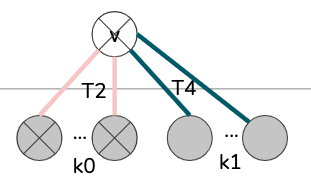

$P(A_{L,0} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v wears a mask} | R)$

$ = 1 - (1 - T_2)^{k_0} * (1 - T_4)^{k_1}$

### 4.1 $P(A_{L,1} | R)$

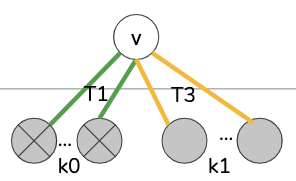

$P(A_{L,1} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v doesn't a mask} | R)$

$ = 1 - (1 - T_1)^{k_0} * (1 - T_3)^{k_1}$

T_mask1 : outward effeciency of masks

T_mask2 : inward effeciency of masks

In [1]:
import re
from os import listdir
from os.path import isfile, join
import json
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson
from scipy.special import comb
from scipy import optimize 
import multiprocessing, time
from multiprocessing import Manager
from collections import defaultdict
import collections

'''
Collections of data loading functions
'''



def separate_number_chars(s):
    res = re.split('([-+]?\d+\.\d+)|([-+]?\d+)', s.strip())
    res_f = [r.strip() for r in res if r is not None and r.strip() != '']
    return res_f

def load_ES_analysis_results(change_metric, paras_setting, model_names, exp_time=''):
    '''
    Load ES Analysis Results
    Mask: parellel
    Mutation: parellel
    '''
    
    change_metrics_names = ['m', 'T', 'tm']

    infection_size = dict()
    for model in model_names:
        infection_size[model] = dict()
        print("Model ", model)
        print("change ", change_metric)
        print(paras_setting)

                
        infection_size[model][change_metric] = dict()
        change_metric_path = 'es_analysis/' + model + '_ES_Analysis_change_' + change_metric
        print(change_metric_path)
        paras_settings = [f for f in listdir(change_metric_path) if 'tm' in f]   
        infection_size[model][change_metric][paras_setting] = dict()

        if exp_time == '':
            exp_times = [f for f in listdir(change_metric_path + '/' + paras_setting) if f != '.ipynb_checkpoints']
            exp_time = max(exp_times) # Get the latest results
            print(exp_time)
            

        json_path = change_metric_path + '/' + paras_setting + '/' + exp_time + '/' + 'Results/'
        json_path_list = []

        json_path_list.append(json_path + 'infection_size0.json')
        json_path_list.append(json_path + 'infection_size1.json')
        json_path_list.append(json_path + 'infection_size.json')

        for i, json_path_i in enumerate(json_path_list):
            with open(json_path_i) as json_file:
                infection_size_mask = json.load(json_file)

            infection_size[model][change_metric][paras_setting][i] = \
            list(collections.OrderedDict(sorted(infection_size_mask.items())).values())

            infection_size[model][change_metric][paras_setting][i] = \
            [float(i) for i in infection_size[model][change_metric][paras_setting][i]]
    return infection_size  

def load_PE_analysis_results(change_metric, paras_setting, model_names, exp_time=''):
    '''
    Load PE Analysis Results
    Mask: parellel
    Mutation: parellel
    '''

    change_metrics_names = ['m', 'T', 'tm']
    
    infection_size = dict()
    for model in model_names:
        infection_size[model] = dict()
        print("Model ", model)
        print("change ", change_metric)
        print(paras_setting)

                
        infection_size[model][change_metric] = dict()
        change_metric_path = 'pe_analysis/' + model + '_PE_Analysis_change_' + change_metric
        paras_settings = [f for f in listdir(change_metric_path) if 'tm' in f]   
        infection_size[model][change_metric][paras_setting] = dict()
        
        if exp_time == '':
            exp_times = [f for f in listdir(change_metric_path + '/' + paras_setting) if f != '.ipynb_checkpoints']
            exp_time = max(exp_times) # Get the latest results
        print(exp_time)

        json_path = change_metric_path + '/' + paras_setting + '/' + exp_time + '/' + 'Results/'
        json_path_list = []
        
        print("Here:", json_path)
        json_path_list.append(json_path + 'pe_0_list.json')
        json_path_list.append(json_path + 'pe_1_list.json')
        json_path_list.append(json_path + 'pe_list.json')

        for i, json_path_i in enumerate(json_path_list):
            with open(json_path_i) as json_file:
                infection_size_mask = json.load(json_file)

            infection_size[model][change_metric][paras_setting][i] = \
            list(collections.OrderedDict(sorted(infection_size_mask.items())).values())

            infection_size[model][change_metric][paras_setting][i] = \
            [float(i) for i in infection_size[model][change_metric][paras_setting][i]]
        print('mdlist from PE analysis:', sorted(infection_size_mask.keys()) )
    return infection_size 
            
def plot_mask_mutation_theory_change(change_metric, mean_degree_list, infection_size, model_names):    
    for paras_setting in infection_size[model_names[0]][change_metric].keys():
        
        paras = paras_setting.split('_')
        m = float(separate_number_chars(paras[0])[1])
        T = float(separate_number_chars(paras[1])[1])
        tm1 = float(paras[3])
        tm2 = float(paras[5])
        print("m: %.2f, T:%.2f, tm1:%.2f, tm2:%.2f" %(m,T,tm1,tm2))

        infection_size_mask = infection_size[model_names[0]][change_metric][paras_setting]
        infection_size_mu   = infection_size[model_names[1]][change_metric][paras_setting]

    
        plt.figure()
#         plt.plot(mean_degree_list, np.array(infection_size_mask[2]), 'r.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * m + np.array(infection_size_mask[1]) * (1 - m), 'r.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * m, 'g.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[1]) * (1 - m), 'b.')

#         plt.plot(mean_degree_list, np.array(infection_size_mask[2]) * m, 'g.')
#         plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * (1 - m), 'b.')
# #         plt.plot(mean_degree_list, np.array(infection_size_mask[1]) , 'r.')

        plt.plot(mean_degree_list, np.array(infection_size_mu[2]), 'rx')
        plt.plot(mean_degree_list, np.array(infection_size_mu[0]) , 'gx')
        plt.plot(mean_degree_list, np.array(infection_size_mu[1]) , 'bx')

        plt.legend(["Avg        (Mask model)", "Mask      (Mask model)", "No mask(Mask model)", 
                    "Avg        (Mutation model)", "Strain-1 (Mutation model)", "Strain-2 (Mutation model)"])
        plt.xlabel("Mean Degree")
        plt.ylabel("Infection Fraction")
        title = "Theoretical Epidemic Size\nChange " + change_metric + "\nm:%.2f, T:%.2f, tm1:%.2f, tm2:%.2f"%(m, T, tm1, tm2)
        plt.title(title)         
        
def load_happyfeet_ES_results(base_happy_path, metric='', para_setting='',
                              exp_setting='', sim_model_name='', start_strain=0, from_sirius = True):    
    base_happy_path = data_path + base_happy_path 
    if from_sirius:
        happy_path = base_happy_path + sim_model_name + 'Results_change_' + \
                     metric + '/' + para_setting + '/' +  exp_setting
        exp_times = [f for f in listdir(happy_path) 
                 if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Compare the latest results
        print(exp_time)

        if start_strain == 0:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss1/'
            print("Data from ss1")
        else :
            print("Data from ss1")
            happy_path = happy_path + '/' + exp_time + '/' + 'ss2/'

    else:
        happy_path = base_happy_path
    
    mean_dgree_files = [f for f in listdir(happy_path)]
    
    infection_size0 = defaultdict(list)
    infection_size1 = defaultdict(list)
    cp_raw_results      = defaultdict(list)
    
    
    for idx, mdf in enumerate(mean_dgree_files):
        md = float(separate_number_chars(mdf)[1])
        cpfiles = [f for f in listdir(happy_path + mdf)]
        infection_size0_cp_list = []
        infection_size1_cp_list = []
        cp_results_list = []
        
        for cp_idx, cp in enumerate(cpfiles):
            
            if idx == 0 and cp_idx == 0:
                with open (happy_path + mdf + '/' + cp + '/Settings/paras.json') as jf:
                    paras = json.load(jf)
                    
            np_path = happy_path + mdf + '/' + cp + '/Results/'
            
            infection_size0_cp_list.append(np.load(np_path + 'infSt1.npy'))
            infection_size1_cp_list.append(np.load(np_path + 'infSt2.npy'))  
            
            try:
                with open(np_path + 'results.json', 'r') as fp:# Load raw results
                    exp_results = json.load(fp)
                cp_results_list.append(exp_results)
            except:
                print("cp %s doesn't have raw results" %cp)
            
        infection_size0[md] = np.array(infection_size0_cp_list).mean()
        infection_size1[md] = np.array(infection_size1_cp_list).mean()
        cp_raw_results[md] = cp_results_list
    
    infection_size0_list = list(collections.OrderedDict(sorted(infection_size0.items())).values())
    infection_size1_list = list(collections.OrderedDict(sorted(infection_size1.items())).values())
    return infection_size0_list, infection_size1_list, paras, cp_raw_results     

def load_happyfeet_PE_results(base_happy_path, metric='', para_setting='', 
                              exp_setting='', sim_model_name='', start_strain=0, from_sirius = True):    
    base_happy_path = data_path + base_happy_path 
    if from_sirius:
        happy_path = base_happy_path + sim_model_name + 'Results_change_' + \
                     metric + '/' + para_setting + '/' +  exp_setting
        exp_times = [f for f in listdir(happy_path) 
                 if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Compare the latest results
        print(exp_time)

        if start_strain == 0:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss1/'
        else:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss2/'
    else:
        happy_path = base_happy_path
    
    mean_dgree_files = [f for f in listdir(happy_path)]
    infection_size0 = defaultdict(list)

    
    for idx, mdf in enumerate(mean_dgree_files):
        md = float(separate_number_chars(mdf)[1])
        cpfiles = [f for f in listdir(happy_path + mdf)]
        infection_size0_cp_list = []
        
        for cp_idx, cp in enumerate(cpfiles):
            
            if idx == 0 and cp_idx == 0:
                with open (happy_path + mdf + '/' + cp + '/Settings/paras.json') as jf:
                    paras = json.load(jf)
                    
            np_path = happy_path + mdf + '/' + cp + '/Results/'
#             print(np_path)
            infection_size0_cp_list.append(np.load(np_path + 'Prob_Emergence.npy'))
        
        infection_size0[md] = np.array(infection_size0_cp_list).mean()

    
    infection_size0_list = list(collections.OrderedDict(sorted(infection_size0.items())).values())

    return infection_size0_list, paras 

# def load_old_path_sim_results(metric, exp_setting):
#     sim_mask_path = '../../../Mask2Results_change_' + metric + '/'
#     exp_times = [f for f in listdir(sim_mask_path) 
#                      if f != '.ipynb_checkpoints' and exp_setting in f]
#     exp_time = max(exp_times) # Compare the latest results
#     np_path = sim_mask_path + exp_time + "/Results/start-mask/"
#     if0 = np.load(np_path + "infSt1.npy")
#     if1 = np.load(np_path + "infSt2.npy")
    
#     with open (sim_mask_path + exp_time + "/Settings/paras.json") as js:
#         paras_sim = json.load(js)
#     return if0, if1, paras_sim

def load_ES_sim_results(change_metric, paras_setting,):
    sim_mask_path = data_path + 'simulation/Mask_Simulation_change_' + change_metric + '/' + paras_setting + '/'
    exp_times = [f for f in listdir(sim_mask_path) 
                     if f != '.ipynb_checkpoints']
    exp_time = max(exp_times) # Compare the latest results
    print(exp_time)
    np_path0 = sim_mask_path + exp_time + "/Results/start-mask/"

    if0 = np.load(np_path0 + "infSt1.npy")
    if1 = np.load(np_path0 + "infSt2.npy")
    
    with open (sim_mask_path + exp_time + "/Settings/paras.json") as js:
        paras_sim = json.load(js)
        
    return if0, if1, paras_sim

def load_PE_sim_results(change_metric, paras_setting,exp_time = ''):
    sim_mask_path = data_path + 'simulation/Mask_Simulation_change_' + change_metric + '/' + paras_setting + '/'
    if exp_time == '':
        exp_times = [f for f in listdir(sim_mask_path) 
                         if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Compare the latest results
        print(exp_time)
    np_path0 = sim_mask_path + exp_time + "/Results/start-mask/"
    np_path1 = sim_mask_path + exp_time + "/Results/start-nomask/"

    
    pe0 = np.load(np_path0 + "Prob_Emergence.npy")
    pe1 = np.load(np_path1 + "Prob_Emergence.npy")
    
    with open (sim_mask_path + exp_time + "/Settings/paras.json") as js:
        paras_sim = json.load(js)
        
    return pe0, pe1, paras_sim



def div(x, y):
    if y == 0:
        return 0
    else:
        return x*1.0/y
    
def resolve_rawdata(raw_results, check_point, thrVal):
    '''
    Load raw ES data from Ray
    raw_results from only 1 strain
    '''
    Prob_Emergence = []
    AvgValidSize = []
#     AvgSize = []
#     StdValidSize = []
    infSt1 = []
    infSt2 = []

    ordered_raw = list(collections.OrderedDict(sorted(raw_results.items())).values())
    
    for idx, res in enumerate(ordered_raw):
        num_cps = len(res) 

        ttlEpidemicsSize = 0
        numEpidemics_1 = 0
        numEpidemics_2 = 0
        numEpidemics = 0
        Epidemics = []
        EpidemicsPerSt = [0,0,0]
        fractionDic = dict()
        infectedPerStDic = dict()
        ttlFrac = 0


        for cp in range(num_cps):
            result = res[cp]
            for ii in range(check_point):
                fractionDic[ii] = result[ii][0] ###
                infectedPerStDic[ii] = result[ii][1] ###
                if fractionDic[ii] >= thrVal:
                    numEpidemics += 1
                    ttlEpidemicsSize += fractionDic[ii]
                    Epidemics.append(fractionDic[ii])
                    EpidemicsPerSt[0] += infectedPerStDic[ii][0]
                    EpidemicsPerSt[1] += infectedPerStDic[ii][1]

                ttlFrac += fractionDic[ii]

        Prob_Emergence.append(numEpidemics*1.0/(check_point * num_cps))
        AvgValidSize.append(div(ttlEpidemicsSize*1.0, numEpidemics))
#         AvgSize.append(ttlFrac*1.0/check_point)
#         StdValidSize.append(np.std(Epidemics))
        infSt1.append(div(EpidemicsPerSt[0],numEpidemics))
        infSt2.append(div(EpidemicsPerSt[1],numEpidemics))
        
    return np.array(infSt1), np.array(infSt2), np.array(AvgValidSize), np.array(Prob_Emergence), sorted(raw_results.keys())
    
    
def load_happyfeet_raw_results(base_happy_path, metric='', para_setting='',
                              exp_setting='', sim_model_name='', start_strain=0, exp_time='', from_sirius = True):    
    print('load_happyfeet_raw_results:', para_setting)
    base_happy_path = data_path + base_happy_path 
    if from_sirius:
        happy_path = base_happy_path + sim_model_name + 'Results_change_' + \
                     metric + '/' + para_setting + '/' +  exp_setting
        
        if exp_time == '':
            exp_times = [f for f in listdir(happy_path) 
                     if f != '.ipynb_checkpoints' ]
            exp_time = max(exp_times) # Compare the latest results
            
        print(exp_time)

        if start_strain == 0:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss1/'
            print("Data from ss1")
        else :
            print("Data from ss2")
            happy_path = happy_path + '/' + exp_time + '/' + 'ss2/'

    else:
        happy_path = base_happy_path
    
    mean_dgree_files = [f for f in listdir(happy_path)]
    
#     infection_size0 = defaultdict(list)
#     infection_size1 = defaultdict(list)
    cp_raw_results = defaultdict(list)
    
    
    for idx, mdf in enumerate(mean_dgree_files):
        md = float(separate_number_chars(mdf)[1])
        cpfiles = [f for f in listdir(happy_path + mdf)]
#         infection_size0_cp_list = []
#         infection_size1_cp_list = []
        cp_results_list = []
        
        for cp_idx, cp in enumerate(cpfiles):
            
            if idx == 0 and cp_idx == 0:
                with open (happy_path + mdf + '/' + cp + '/Settings/paras.json') as jf:
                    paras = json.load(jf)
                    
            np_path = happy_path + mdf + '/' + cp + '/Results/'
            
#             infection_size0_cp_list.append(np.load(np_path + 'infSt1.npy'))
#             infection_size1_cp_list.append(np.load(np_path + 'infSt2.npy'))  
            
            try:
                with open(np_path + 'results.json', 'r') as fp:# Load raw results
                    exp_results = json.load(fp)
                cp_results_list.append(exp_results)
            except:
                print("cp %s doesn't have raw results" %cp)
            
#         infection_size0[md] = np.array(infection_size0_cp_list).mean()
#         infection_size1[md] = np.array(infection_size1_cp_list).mean()
        cp_raw_results[md] = cp_results_list
    
#     infection_size0_list = list(collections.OrderedDict(sorted(infection_size0.items())).values())
#     infection_size1_list = list(collections.OrderedDict(sorted(infection_size1.items())).values())
    return cp_raw_results, paras,    


    
def load_all_valid_results(metric='m', 
                           para_setting='m0.45_T0.60_tm1_0.30_tm2_0.70', 
                           base_happy_path = 'happyfeet/', sim_model_names = ['Mask2', ], thrVal=0.05):
    '''
    Not very useful
    '''
    base_happy_path = data_path + base_happy_path 
    sim_model_name = sim_model_names[0]
    
    happy_path = base_happy_path + sim_model_name + 'Results_change_' + \
                     metric + '/' + para_setting + '/'
    print(happy_path)
    exp_setting_files = [f for f in listdir(happy_path) if f != '.ipynb_checkpoints']

    es0 = []
    es1 = []
    es  = []
    pe0 = []
    pe1 = []
    total_exp_es = 0
    total_exp_pe = 0
    for exp_setting in exp_setting_files:
        print(exp_setting)
        exp_num = int(separate_number_chars(exp_setting)[3])
        exp_time_files = [f for f in listdir(happy_path + exp_setting + '/') if f != '.ipynb_checkpoints']
        for exp_time in exp_time_files:
            total_exp_es += exp_num * 2
            total_exp_pe += exp_num 
            print(exp_time)
            
            raw_ss1, paras = load_happyfeet_raw_results(base_happy_path, metric, 
                                                        para_setting, 
                                                        exp_setting, 
                                                        sim_model_name, 
                                                        exp_time=exp_time,
                                                        start_strain=0)
            raw_ss2, paras = load_happyfeet_raw_results(base_happy_path, metric, 
                                                        para_setting, 
                                                        exp_setting, 
                                                        sim_model_name, 
                                                        exp_time=exp_time,
                                                        start_strain=1)
            check_point = paras['e']
            m = paras['m']
            es0_s1, es1_s1, es_s1, pe0_s1 = resolve_rawdata(raw_ss1, check_point, thrVal)
            es0_s2, es1_s2, es_s2, pe1_s2 = resolve_rawdata(raw_ss2, check_point, thrVal)
            
            
            es0.append((es0_s1  + es0_s2)/2)
            es1.append((es1_s1  + es1_s2)/2)
            es.append((es_s1 + es_s2)/2)
            pe0.append(pe0_s1)
            pe1.append(pe1_s2)
    
    es0 = np.array(es0)
    es1 = np.array(es1)
    es  = np.array(es)
    pe0 = np.array(pe0)
    pe1 = np.array(pe1)
    
    
    
    return np.mean(es0, axis = 0), np.mean(es1, axis = 0), np.mean(es, axis = 0),np.mean(pe0, axis = 0), np.mean(pe1, axis = 0), total_exp_es, total_exp_pe
        
        
    

        
def load_sirius_rawdata(change_metric, paras_setting,exp_time=''):
    sim_mask_path = data_path + 'simulation/Mask_Simulation_change_' + change_metric + '/' + paras_setting + '/'
#     sim_mask_path = 'simulation/Mask_Simulation_change_' + change_metric + '/' + paras_setting + '/'
    if exp_time == '':
        exp_times = [f for f in listdir(sim_mask_path) 
                         if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Compare the latest results
    
    print(exp_time)
    np_path0 = sim_mask_path + exp_time + "/Results/start-mask/"
    np_path1 = sim_mask_path + exp_time + "/Results/start-nomask/"
    
    with open(np_path0 + 'raw_data.json') as jf:
        raw_0 = json.load(jf)
    with open(np_path1 + 'raw_data.json') as jf:
        raw_1 = json.load(jf)
    
#     pe0 = np.load(np_path0 + "Prob_Emergence.npy")
#     pe1 = np.load(np_path1 + "Prob_Emergence.npy")
    
    with open (sim_mask_path + exp_time + "/Settings/paras.json") as js:
        paras_sim = json.load(js)
        
    return raw_0, raw_1, paras_sim    

def load_dm5_change_m_ES(thrVal0 = 0.1, thrVal1 = 0.1):

    m_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    metric_analysis = 'm'
#     para_setting = 'm0.1_T0.60_tm1_0.30_tm2_0.70'
    sim_model_names = ['Mask2', ]
    model_names_es = ['Mask', ]
    model_names_pe = ['Mask', 'Mutation']
    base_happy_path = 'happyfeet/'
    sim_metric = 'm'
    exp_setting = 'n5000000_totalexp200'
    sim_model_name = sim_model_names[0]
    
    es0_theory_list = []
    es1_theory_list = []
    es_theory_list  = []
    pe0_theory_list = []
    pe1_theory_list = []
    pe_theory_list  = []
    
    
    es0_sim_list = []
    es1_sim_list = []
    es_sim_list  = []
    pe0_sim_list = []
    pe1_sim_list = []
    
    other_para_setting = 'T0.60_tm1_0.30_tm2_0.70'
    
    for m in m_list:
        
        para_setting = 'm' + str(m) + '_' + other_para_setting
        print(para_setting)
        
        raw_ss1, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
                                    para_setting, 
                                    exp_setting, 
                                    sim_model_name, 
                                    0)
        raw_ss2, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
                                    para_setting, 
                                    exp_setting, 
                                    sim_model_name, 
                                    1)
        check_point = paras['e']
        
        es0, es1, es, pe0, mlss1 = resolve_rawdata(raw_ss1, check_point, thrVal0)
        es0_, es1_, es_, pe1, mlss2 = resolve_rawdata(raw_ss2, check_point, thrVal1)
        
        print(mlss1)
        print(mlss2)
        es0_sim_list.append(es0)
        es1_sim_list.append(es1)
        es_sim_list.append(np.array(es0) * m + np.array(es1) * (1 - m))
        pe0_sim_list.append(pe0)
        pe1_sim_list.append(pe1)
        
        

        
        infection_size = load_ES_analysis_results(metric_analysis, para_setting, model_names_es)
        probability_e  = load_PE_analysis_results(metric_analysis, para_setting, model_names_pe)
        
        es0_theory = np.array(infection_size[model_names[0]][metric_analysis][para_setting][0]) * m
        es1_theory = np.array(infection_size[model_names[0]][metric_analysis][para_setting][1]) * (1 - m)
        
        pe0_theory = np.array(probability_e[model_names[0]][metric_analysis][para_setting][0]) 
        pe1_theory = np.array(probability_e[model_names[0]][metric_analysis][para_setting][1]) 

        
        
        es0_theory_list.append(es0_theory)
        es1_theory_list.append(es1_theory)
        es_theory_list.append(es0_theory + es1_theory)
        
        pe0_theory_list.append(pe0_theory)
        pe1_theory_list.append(pe1_theory)
        pe_theory_list.append(pe0_theory * m + pe1_theory * (1 - m))
#     print('pe0_theory_list:', pe0_theory_list)
#     print('pe1_theory_list:', pe1_theory_list)
#     print(pe_theory_list)
    
#     print(pe0_sim_list)
#     print(pe1_sim_list)
    
        
    print(es0_theory_list)
        
    plt.figure()
    plt.plot(m_list, es0_theory_list, 'g--', )
    plt.plot(m_list, es1_theory_list, 'b--', )
    plt.plot(m_list, es_theory_list, 'r--', )
    
    plt.scatter(m_list, es0_sim_list, facecolors='none', edgecolors='g')
    plt.scatter(m_list, es1_sim_list, facecolors='none', edgecolors='b')
    plt.scatter(m_list, np.array(es0_sim_list) + np.array(es1_sim_list),  facecolors='none', edgecolors='r')
    
    plt.legend([
            "Theory(mask)", 
            "Theory(no mask)",
            "Theory(total)",

           "Sim(mask)", 
            "Sim(no mask)",
            "Sim(total)"
    ],)
    
    plt.xlabel('m')
    plt.ylabel('frac')
    
    title = "Mask model Epidemic Size for different m"  + "\n" + other_para_setting + "\n" + exp_setting + '\nmean_degree = 5'
    # title = "Mutation model Epidemic Size"  + "\n" + 'T1: %.2f, T2: %.2f'%(q_dict['Q1'], q_dict['Q2']) + "\n" 
    plt.title(title)
    
#     plt.figure()
#     plt.plot(m_list, pe0_theory_list, 'g--', )
#     plt.plot(m_list, pe1_theory_list, 'b--', )
#     plt.plot(m_list, pe_theory_list, 'r--', )
    
#     plt.scatter(m_list, np.array(pe0_sim_list) , facecolors='none', edgecolors='g')
#     plt.scatter(m_list, np.array(pe1_sim_list) , facecolors='none', edgecolors='b')
# #     plt.scatter(m_list, np.array(pe0_sim_list) * m + np.array(pe1_sim_list) * (1 - m),  facecolors='none', edgecolors='r')
    
    
    
#     plt.legend([
#             "Theory(mask)", 
#             "Theory(no mask)",
#             "Theory(total)",

#            "Sim(mask)", 
#             "Sim(no mask)",
#             "Sim(total)"
#     ],)
    
#     plt.xlabel('m')
#     plt.ylabel('Probability')
    
#     title = "Mask model Probability of Emergence for different m"  + "\n" + other_para_setting + "\n" + exp_setting + '\nmean_degree = 5'
#     # title = "Mutation model Epidemic Size"  + "\n" + 'T1: %.2f, T2: %.2f'%(q_dict['Q1'], q_dict['Q2']) + "\n" 
#     plt.title(title)

def get_md5_pe(thrVal0 = 0.05):
    metric_analysis = 'm'
    sim_model_names = ['Mask2', ]
    base_happy_path = 'simulation/'
    sim_metric = 'm'
    exp_setting = 'n5000_totalexp1000'
    sim_model_name = sim_model_names[0]
    model_names = ['Mask',]
# para_setting = 'm0.1_T0.60_tm1_0.30_tm2_0.70'
    tran_theory_list = []
    tran_sim_list = []
    
    tran_theory_list0 = []
    tran_sim_list0 = []
    
    tran_theory_list1 = []
    tran_sim_list1 = []
    m_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for m in m_list:
        # '''Load  raw simulation results for ES(new path)'''

        para_setting = 'm'+ str(m) + '_T0.60_tm1_0.30_tm2_0.70'


        raw_ss1_0925, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
                                            para_setting, 
                                            exp_setting, 
                                            sim_model_name, 
                                            start_strain=0, )

        raw_ss2_0925, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
                                            para_setting, 
                                            exp_setting, 
                                            sim_model_name, 
                                            start_strain=1, )
        prob_emergence = load_PE_analysis_results(metric_analysis, para_setting, model_names)
        pe0_theory = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][0]) 
        pe1_theory = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][1]) 
        pe_theory  = pe0_theory * m + pe1_theory * (1 - m)
        
        check_point = paras['e']
#         check_point = 50
        es0_s1_0923, es1_s1_0923, es_s1_0923, pe0, mlist0 = resolve_rawdata(raw_ss1_0925, check_point, thrVal0)
        es0_s1_0923, es1_s1_0923, es_s1_0923, pe1, mlist1 = resolve_rawdata(raw_ss2_0925, check_point, thrVal0)
        
        pe0_sim = pe0[25]
        pe1_sim = pe1[25]
        pe_sim = pe0 * m + pe1 * (1 - m)
        
        
#         pe_sim = np.array(pe0) * m + np.array(pe1) * (1 - m)
#         pe_sim_right_shift = list(pe_sim[1:])
#         pe_sim_right_shift.append(1)
#         pe_sim_right_shift = np.array(pe_sim_right_shift)
#         pe_sim_res = abs(pe_sim_right_shift - pe_sim)
# #         if m != 0.9:
#         tran_theory = mean_degree_list[np.where(pe_sim_res > 10 ** (-4))[0][0]]
#         tran_sim = mean_degree_list[np.where(pe_sim_res > 0)[0][0]]
        tran_theory_list.append(pe_theory[25])
#         tran_sim_list.append(pe_sim)
        
        tran_theory_list0.append(pe0_theory[25])
        tran_sim_list0.append(pe0_sim)
        
        tran_theory_list1.append(pe1_theory[25])
        tran_sim_list1.append(pe1_sim)
    
    plt.figure()
    plt.plot(m_list, tran_theory_list0, 'g--')
    plt.plot(m_list, tran_theory_list1, 'b--')
    plt.plot(m_list, np.array(tran_theory_list0) * m + np.array(tran_theory_list1) * (1 - m), 'r--')
    
    
    plt.scatter(m_list, tran_sim_list0 , facecolors='none', edgecolors='g')
    plt.scatter(m_list, tran_sim_list1 , facecolors='none', edgecolors='b')
    plt.scatter(m_list, np.array(tran_sim_list0) * m + np.array(tran_sim_list1)* (1 - m), facecolors='none', edgecolors='r')
    
    plt.xlabel('m')
    plt.ylabel('Probability')
    plt.title('Probability of Emergence for Mask Model\nMean degree = 5')
    plt.legend([
                'Theory(mask)',
                'Theory(no-mask)',
                'Theory(total)',
                'Simulation(mask)',
                'Simulation(no-mask)',
                'Simulation(total)',
    ])
    
def get_transition_points(thrVal0 = 0.15):
    metric_analysis = 'm'
    sim_model_names = ['Mask2', ]
    base_happy_path = 'simulation/'
    sim_metric = 'm'
    exp_setting = 'n5000_totalexp1000'
    sim_model_name = sim_model_names[0]
    model_names = ['Mask',]
# para_setting = 'm0.1_T0.60_tm1_0.30_tm2_0.70'
    tran_theory_list = []
    tran_sim_list = []
    m_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for m in m_list:
        # '''Load  raw simulation results for ES(new path)'''

        para_setting = 'm'+ str(m) + '_T0.60_tm1_0.30_tm2_0.70'


        raw_ss1_0925, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
                                            para_setting, 
                                            exp_setting, 
                                            sim_model_name, 
                                            start_strain=0, )

        raw_ss2_0925, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
                                            para_setting, 
                                            exp_setting, 
                                            sim_model_name, 
                                            start_strain=1, )
        prob_emergence = load_PE_analysis_results(metric_analysis, para_setting, model_names)
        
        check_point = paras['e']
#         check_point = 50
        es0_s1_0923, es1_s1_0923, es_s1_0923, pe0, mlist0 = resolve_rawdata(raw_ss1_0925, check_point, thrVal0)
        es0_s1_0923, es1_s1_0923, es_s1_0923, pe1, mlist1 = resolve_rawdata(raw_ss2_0925, check_point, thrVal0)
        
        pe_theory = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][0]) * m + np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][1]) * (1 - m)
        pe_sim = np.array(pe0) * m + np.array(pe1) * (1 - m)
        pe_sim_right_shift = list(pe_sim[1:])
        pe_sim_right_shift.append(1)
        pe_sim_right_shift = np.array(pe_sim_right_shift)
        pe_sim_res = abs(pe_sim_right_shift - pe_sim)
#         if m != 0.9:
        tran_theory = mean_degree_list[np.where(pe_sim_res > 10 ** (-4))[0][0]]
        tran_sim = mean_degree_list[np.where(pe_sim_res > 0)[0][0]]
        tran_theory_list.append(tran_theory)
        tran_sim_list.append(tran_sim)
    
    plt.figure()
    plt.plot(m_list, tran_theory_list, 'r+')
#     plt.plot(m_list, tran_sim_list, 'cx')
    plt.scatter(m_list, tran_sim_list , facecolors='none', edgecolors='c')
    plt.xlabel('m')
    plt.ylabel('Mean degree')
    plt.title('Transition point of Probability for Mask model')
    plt.legend([
                'Theory',
                'Simulation'])

def resolve_sirius_raw(raw_data, thrVal):
    
    Prob_Emergence = []
    AvgValidSize = []
    
    for mean_degree, md_res in raw_data.items():
        
#         print("Mean degree:", mean_degree)
        
        ttlEpidemicsSize = 0
        numEpidemics_1 = 0
        numEpidemics_2 = 0
        numEpidemics = 0
        Epidemics = []
        EpidemicsPerSt = [0,0,0]
        fractionDic = dict()
        infectedPerStDic = dict()
        ttlFrac = 0
        
        fractionDic = md_res
        numExp = len(fractionDic.keys())
        
        for ii in fractionDic.keys():
            if fractionDic[ii] >= thrVal:
                numEpidemics += 1
                ttlEpidemicsSize += fractionDic[ii]
                Epidemics.append(fractionDic[ii])


            ttlFrac += fractionDic[ii]

        if len(Epidemics) == 0:
            Epidemics.append(0)


        ######### Record the results for this Mean Degree ##########    
        Prob_Emergence.append(numEpidemics*1.0/(numExp))
        AvgValidSize.append(div(ttlEpidemicsSize*1.0, numEpidemics))


    return np.array(AvgValidSize), np.array(Prob_Emergence), sorted(raw_data.keys())


degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script
mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

data_path = '/mnt/hdd-storage/ytian/ns/'

# Change m = [0.1, 0.9], mean_degree = 5

In [2]:
def load_dm5_change_ES(thrVal0 = 0.05, thrVal1 = 0.05, metric_analysis = 'T', which_tm=1, 
                       exp_setting = 'n5000000_totalexp200'):

    m_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     m_list = [ 0.8, 0.9]
# 'n5000000_totalexp200'
    

    sim_model_names = ['Mask2', ]
    model_names = ['Mask',]
    base_happy_path = 'simulation/'
    sim_metric = metric_analysis
    
    sim_model_name = sim_model_names[0]
    
    es0_theory_list = []
    es1_theory_list = []
    es_theory_list  = []
    
    es0_sim_list = []
    es1_sim_list = []
    es_sim_list  = []
    
    
    pe0_theory_list = []
    pe1_theory_list = []
    pe_theory_list  = []
    
    pe0_sim_list = []
    pe1_sim_list = []
    pe_sim_list  = []
    
    
    for m in m_list:

        print('\n\nchange ' + metric_analysis + '=%.2f'%m )
        
        if metric_analysis == 'm':
            para_setting = ('m' + str(m) + '_' + 'T0.60_tm1_0.30_tm2_0.70')
            
        elif metric_analysis == 'tm':
            if which_tm == 1:
                para_setting = 'm0.45_T0.60_tm1_%.2f_tm2_0.70'%m
                
            else:
                para_setting = 'm0.45_T0.60_tm1_0.30_tm2_%.2f'%m

        elif metric_analysis == 'T':
            para_setting = ('m0.45_T%.2f_tm1_0.30_tm2_0.70'%m)

        else:
            assert False
            print("No such metric!!")
#         print(para_setting)
        
        raw_ss1, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
                                    para_setting, 
                                    exp_setting, 
                                    sim_model_name, 
#                                     exp_time = '092801:13',
                                    start_strain=0)
        raw_ss2, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
                                    para_setting, 
                                    exp_setting, 
                                    sim_model_name, 
#                                     exp_time = '092801:13',
                                    start_strain=1)
        check_point = paras['e']
        print(paras)
        
        es0, es1, es, pe0, ml = resolve_rawdata(raw_ss1, check_point, thrVal0)
        es0_, es1_, es_, pe1, ml = resolve_rawdata(raw_ss2, check_point, thrVal1)
        
        pe = pe0 * paras['m'] + pe1 * (1 - paras['m'])
        
        print('pe', pe)
        
#         if m < 0.7:
#             es0_sim_list.append(es0[25])
#             es1_sim_list.append(es1[25])
#             es_sim_list.append(es[25])

#             pe0_sim_list.append(pe0[25])
#             pe1_sim_list.append(pe1[25])
#             pe_sim_list.append(pe[25])
#         else:
        es0_sim_list.append(es0)
        es1_sim_list.append(es1)
        es_sim_list.append(es)

        pe0_sim_list.append(pe0)
        pe1_sim_list.append(pe1)
        pe_sim_list.append(pe)
        
        

        print("\nLoad analysis!")
        infection_size = load_ES_analysis_results(metric_analysis, para_setting, model_names)
        prob_emergence = load_PE_analysis_results(metric_analysis, para_setting, model_names, )
        print("Load analysis done!")
        
        if m == 0.9:
            es0_theory = np.array(infection_size[model_names[0]][metric_analysis][para_setting][0]) * 0.45
            es1_theory = np.array(infection_size[model_names[0]][metric_analysis][para_setting][1]) * (1 - 0.45)
            print(es0_theory)
        else:
            es0_theory = np.array(infection_size[model_names[0]][metric_analysis][para_setting][0]) * 0.45
            es1_theory = np.array(infection_size[model_names[0]][metric_analysis][para_setting][1]) * (1 - 0.45)
            print(es0_theory)
        

        es0_theory_list.append(es0_theory)
        es1_theory_list.append(es1_theory)
        es_theory_list.append(es0_theory + es1_theory)

        pe0_theory = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][0][25]) 
        pe1_theory = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][1][25]) 
        pe_theory  = pe0_theory * paras['m'] + pe1_theory * (1 - paras['m'])

        pe0_theory_list.append(pe0_theory)
        pe1_theory_list.append(pe1_theory)
        pe_theory_list.append(pe_theory)
      
            
        
#     pe0_sim_list[0] = pe0_theory_list[0]
#     pe1_sim_list[0] = pe1_theory_list[0]
#     pe_sim_list[0] = pe_theory_list[0]
        
#     pe0_sim_list[-1] = pe0_theory_list[-1]
#     pe1_sim_list[-1] = pe1_theory_list[-1]
#     pe_sim_list[-1] = pe_theory_list[-1]
      
    if metric_analysis == 'tm':
        if which_tm == 1:
            
            metric_analysis = 'Tmask1'
        else:
            metric_analysis = 'Tmask2'
        
    plt.figure(figsize=(7, 5))
    plt.plot(m_list, es0_theory_list, 'g--', )
    plt.plot(m_list, es1_theory_list, 'b--', )
    plt.plot(m_list, es_theory_list, 'r--', )
    
    plt.scatter(m_list, es0_sim_list, facecolors='none', edgecolors='g')
    plt.scatter(m_list, es1_sim_list, facecolors='none', edgecolors='b')
    plt.scatter(m_list, np.array(es0_sim_list) + np.array(es1_sim_list),  facecolors='none', edgecolors='r')
    
    plt.legend([
            "Theory(mask)", 
            "Theory(no mask)",
            "Theory(total)",

           "Simulation(mask)", 
            "Simulation(no mask)",
            "Simulation(total)"
    ],)
    
    plt.xlabel(metric_analysis)
    plt.ylabel('Fraction')
    
    title = "Epidemic Size for Mask model\nMean degree = 5" 
    # title = "Mutation model Epidemic Size"  + "\n" + 'T1: %.2f, T2: %.2f'%(q_dict['Q1'], q_dict['Q2']) + "\n" 
    plt.title(title) 
    
    
    plt.figure(figsize=(7, 5))
    plt.plot(m_list, pe0_theory_list, 'g--', )
    plt.plot(m_list, pe1_theory_list, 'b--', )
    plt.plot(m_list, pe_theory_list, 'r--', )
    
    plt.scatter(m_list, pe0_sim_list, facecolors='none', edgecolors='g')
    plt.scatter(m_list, pe1_sim_list, facecolors='none', edgecolors='b')
    plt.scatter(m_list, pe_sim_list,  facecolors='none', edgecolors='r')
    
    plt.legend([
            "Theory(mask)", 
            "Theory(no mask)",
            "Theory(total)",

           "Simulation(mask)", 
            "Simulation(no mask)",
            "Simulation(total)"
    ],)
    
    
            
    plt.xlabel(metric_analysis)
    plt.ylabel('Fraction')
    
    title = "Probability for Mask model\nMean degree = 5" 
    # title = "Mutation model Epidemic Size"  + "\n" + 'T1: %.2f, T2: %.2f'%(q_dict['Q1'], q_dict['Q2']) + "\n" 
    plt.title(title) 

In [3]:
degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script
mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

In [4]:
load_dm5_change_ES(thrVal0=0.05, thrVal1=0.05, metric_analysis = 'tm', which_tm=2)



change tm=0.10
load_happyfeet_raw_results: m0.45_T0.60_tm1_0.30_tm2_0.10
092116:38
Data from ss1
load_happyfeet_raw_results: m0.45_T0.60_tm1_0.30_tm2_0.10
092116:38
Data from ss2
{'e': 100, 'n': 5000000, 'th': 0.01, 'tm1': 0.3, 'tm2': 0.1, 'm': 0.45, 'T': 0.6, 'md': 5, 'ns': 1, 'meandegree': 5.0, 'start_strain ': 2, 'check_point': 1}
pe [0.527]

Load analysis!
Model  Mask
change  tm
m0.45_T0.60_tm1_0.30_tm2_0.10
es_analysis/Mask_ES_Analysis_change_tm
092018:23
Model  Mask
change  tm
m0.45_T0.60_tm1_0.30_tm2_0.10
092820:35
Here: pe_analysis/Mask_PE_Analysis_change_tm/m0.45_T0.60_tm1_0.30_tm2_0.10/092820:35/Results/
mdlist from PE analysis: ['5.0']
Load analysis done!
[0.05078514]


IndexError: list index out of range

In [5]:
# load_dm5_change_m_ES(thrVal0 = 0.03, thrVal1 = 0.03)

# Plot ES theory v.s. simulation

In [107]:
'''Load  ES analysis results'''
print('Load ES analysis results')

# model_names = ['Mask', 'Mutation']
model_names = ['Mask',]
metric_analysis = 'm'
para_setting = 'm0.6_T0.70_tm1_0.40_tm2_0.60'

infection_size = load_ES_analysis_results(metric_analysis, para_setting, model_names, exp_time='092618:13')



infection_size['Mask'][metric_analysis][para_setting][0][10] = 0
infection_size['Mask'][metric_analysis][para_setting][1][10] = 0
infection_size['Mask'][metric_analysis][para_setting][2][10] = 0


# infection_size[model_names[1]][metric_analysis][para_setting][0][10] = 0
# infection_size[model_names[1]][metric_analysis][para_setting][1][10] = 0
# infection_size[model_names[1]][metric_analysis][para_setting][2][10] = 0

ES0 = np.array(infection_size['Mask'][metric_analysis][para_setting][0]) 
ES1 = np.array(infection_size['Mask'][metric_analysis][para_setting][1]) 
ES = ES1 + ES0



Load ES analysis results
Model  Mask
change  m
m0.6_T0.70_tm1_0.40_tm2_0.60
es_analysis/Mask_ES_Analysis_change_m


In [108]:
# '''Load  raw simulation results for ES(new path)'''

# sim_model_names = ['Mask2', ]
# base_happy_path = data_path + 'simulation/'
# sim_metric = 'm'
# exp_setting = 'n5000_totalexp1000'
# sim_model_name = sim_model_names[0]

# raw_ss1, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     start_strain=0, )

# raw_ss2, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     start_strain=1, )


# m = paras['m']
# T = paras['T']
# tm1 = paras['tm1']
# tm2 = paras['tm2']
# paras

In [109]:
'''
Play with threshold for ES using raw results
'''
degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script
mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

check_point = paras['e']
thrVal = 0.0001
es0_s1, es1_s1, es_s1, pe0, ml0 = resolve_rawdata(raw_ss1, check_point, thrVal)
# es0_s2, es1_s2, es_s2, pe1, ml1 = resolve_rawdata(raw_ss2, check_point, thrVal)

es0 = es0_s1
es1 = es1_s1 

es = es0 + es1

# print(ml0)
start = np.where(mean_degree_list == ml0[0])[0][0]
end   = np.where(mean_degree_list == ml0[-1])[0][0] + 1

mean_degree_list_plot = mean_degree_list[start: end]
ES0_plot = list(ES0)[start: end]
ES1_plot = list(ES1)[start: end]
ES_plot  = list(ES)[start: end]
# print(ml0)
# print(mean_degree_list_plot)

NameError: name 'paras' is not defined

NameError: name 'ES0_mu' is not defined

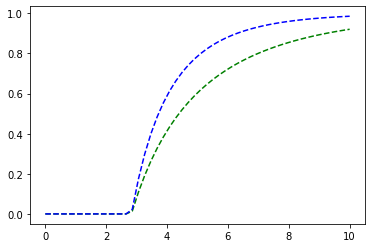

In [110]:
'''
Plot ES analysis v.s. simulation
'''

mean_degree_list_plot = mean_degree_list

# plt.plot(mean_degree_list_plot, ES0_plot, 'g--')
# plt.plot(mean_degree_list_plot, ES1_plot, 'b--')
# plt.plot(mean_degree_list_plot, ES_plot, 'r--')

plt.plot(mean_degree_list_plot, ES0, 'g--')
plt.plot(mean_degree_list_plot, ES1, 'b--')
# plt.plot(mean_degree_list_plot, ES, 'r--')

plt.plot(mean_degree_list_plot, ES0_mu, 'g.')
plt.plot(mean_degree_list_plot, ES1_mu, 'b.')
# plt.plot(mean_degree_list_plot, ES_mu, 'r.')


# plt.plot(mean_degree_list, infection_size[model_names[1]][metric_analysis][para_setting][0], 'g.')
# plt.plot(mean_degree_list, infection_size[model_names[1]][metric_analysis][para_setting][1], 'b.')
# plt.plot(mean_degree_list, np.array(infection_size[model_names[1]][metric_analysis][para_setting][0]) + np.array(infection_size[model_names[1]][metric_analysis][para_setting][1]), 'r.')


# plt.scatter(mean_degree_list_plot, np.array(es0), facecolors='none', edgecolors='g')
# plt.scatter(mean_degree_list_plot, np.array(es1), facecolors='none', edgecolors='b')
# plt.scatter(mean_degree_list_plot, np.array(es) , facecolors='none', edgecolors='r')

# plt.scatter(mean_degree_list, np.array(es0_) , 'g+')
# plt.plot(mean_degree_list, np.array(es1_) , 'b+')
# plt.plot(mean_degree_list, np.array(es_), 'r+')

# plt.plot(mean_degree_list, np.array(if0_sirius) , 'gx')
# plt.plot(mean_degree_list, np.array(if1_sirius) , 'bx')
# plt.plot(mean_degree_list, np.array(if0_sirius)  + np.array(if1_sirius), 'rx')

plt.legend([
#             "Mask theory(mask)", 
#             "Mask theory(no mask)",
#             "Mask theory(total)",
            "Theory(mask)", 
            "Theory(no mask)",
#             "Theory(total)",
    
            "Mutation theory(S1)", 
            "Mutation theory(S2)",
#             "Mutation theory(total)", 

#            "Mask simulation(mask)", 
#             "Mask simulation(no mask)",
#             "Mask simulation(total)",
#             "Simulation(mask)", 
#             "Simulation(no mask)",
#             "Simulation(total)",
],)

plt.xlabel("Mean degree")
plt.ylabel("Fraction")
print(para_setting)
title = "Epidemic Size\nMask model v.s. Mutation model"
plt.title(title)

# Mask PE theory v.s. PE simualtion

In [7]:
'''Load  PE analysis results'''
para_setting = 'm0.45_T0.60_tm1_0.30_tm2_0.70'
model_names = ['Mask',]
# '092618:13' # 0.6_0.7_0.4_0.6
# 091519:10 # m0.45_T0.60_tm1_0.30_tm2_0.70
metric_analysis = 'm'
prob_emergence = load_PE_analysis_results('m', para_setting, model_names, exp_time='091519:10')

prob_emergence[model_names[0]][metric_analysis][para_setting][0][10] = 0
prob_emergence[model_names[0]][metric_analysis][para_setting][1][10] = 0
prob_emergence[model_names[0]][metric_analysis][para_setting][2][10] = 0

# prob_emergence[model_names[1]][metric_analysis][para_setting][0][10] = 0
# prob_emergence[model_names[1]][metric_analysis][para_setting][1][10] = 0
# prob_emergence[model_names[1]][metric_analysis][para_setting][2][10] = 0

PE0 = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][0])
PE1 = np.array(prob_emergence[model_names[0]][metric_analysis][para_setting][1])



Model  Mask
change  m
m0.45_T0.60_tm1_0.30_tm2_0.70
091519:10
Here: pe_analysis/Mask_PE_Analysis_change_m/m0.45_T0.60_tm1_0.30_tm2_0.70/091519:10/Results/
mdlist from PE analysis: ['0.0', '0.20408163265306123', '0.40816326530612246', '0.6122448979591837', '0.8163265306122449', '1.0204081632653061', '1.2244897959183674', '1.4285714285714286', '1.6326530612244898', '1.836734693877551', '10.0', '2.0408163265306123', '2.2448979591836737', '2.4489795918367347', '2.6530612244897958', '2.857142857142857', '3.0612244897959187', '3.2653061224489797', '3.4693877551020407', '3.673469387755102', '3.8775510204081636', '4.081632653061225', '4.285714285714286', '4.4897959183673475', '4.6938775510204085', '4.8979591836734695', '5.1020408163265305', '5.3061224489795915', '5.510204081632653', '5.714285714285714', '5.918367346938775', '6.122448979591837', '6.326530612244898', '6.530612244897959', '6.73469387755102', '6.938775510204081', '7.142857142857143', '7.346938775510204', '7.551020408163265', '7.75

In [166]:
# '''Load  raw simulation results for ES(new path)'''
# metric_analysis = 'm'
# para_setting = 'm0.45_T0.60_tm1_0.30_tm2_0.70'
# sim_model_names = ['Mask2', ]
# base_happy_path = 'simulation/'
# sim_metric = 'm'
# exp_setting = 'n50000_totalexp10000'
# sim_model_name = sim_model_names[0]

# raw_ss1, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     start_strain=0, )

# raw_ss2, paras = load_happyfeet_raw_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     start_strain=1, )

# m = paras['m']
# T = paras['T']
# tm1 = paras['tm1']
# tm2 = paras['tm2']
# print(paras)

# PE  = PE0 * m + PE1 * (1 - m)

# '''
# Play with threshold for PE using raw results
# '''

# check_point = paras['e']
# thrVal0 = 0.2

# es0_s1, es1_s1, es_s1, pe0, mlist0 = resolve_rawdata(raw_ss1, check_point, thrVal0)
# es0_s2, es1_s2, es_s2, pe1, mlist1 = resolve_rawdata(raw_ss2, check_point, thrVal0)


# if len(mlist0) < len(mlist1):
#     mlist = mlist0
#     pe1 = pe1[: len(pe0)]
# else:
#     mlist = mlist1
#     pe0 = pe0[: len(pe1)]
    
# pe = pe0 * m + pe1 * (1 - m)
    
# start = np.where(mean_degree_list == mlist[0])[0][0]
# end   = np.where(mean_degree_list == mlist[-1])[0][0] + 1

# mean_degree_list_plot = mean_degree_list[start: end]
# PE0_plot = list(PE0)[start: end]
# PE1_plot = list(PE1)[start: end]
# PE_plot  = list(PE)[start: end]
    
    


In [167]:
# get_md5_pe(0.15)
# get_transition_points(0.15)

092713:26
{'n': 500000, 'e': 10000, 'm': 0.45, 'T': 0.6, 'tm1': 0.3, 'tm2': 0.7, 'th': 0.05, 'md': 3, 'ns': 10}
092817:49
{'n': 5000000, 'e': 1000, 'm': 0.45, 'T': 0.6, 'tm1': 0.3, 'tm2': 0.7, 'th': 0.05, 'md': 10, 'ns': 50}
['2.0', '2.111111111111111', '2.2222222222222223', '2.3333333333333335', '2.4444444444444446', '2.5555555555555554', '2.6666666666666665', '2.7777777777777777', '2.888888888888889', '3.0']
['2.0', '2.111111111111111', '2.2222222222222223', '2.3333333333333335', '2.4444444444444446', '2.5555555555555554', '2.6666666666666665', '2.7777777777777777', '2.888888888888889', '3.0']
mlist [2.0, 2.111111111111111, 2.2222222222222223, 2.3333333333333335, 2.4444444444444446, 2.5555555555555554, 2.6666666666666665, 2.7777777777777777, 2.888888888888889, 3.0]
m0.45_T0.60_tm1_0.30_tm2_0.70


Text(0.5, 1.0, 'Probability of Emergence for Mask model ')

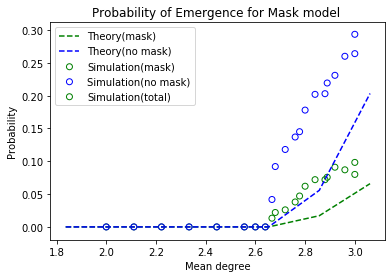

In [23]:
'''
Load raw data from Parellel & Play with threshold for PE
'''

degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script
mean_degree_list = np.linspace(degree_min, degree_max, interval_num,)

thrVal0 = 0.05 # works for m0.45_T0.60_tm1_0.30_tm2_0.70
thrVal1 = 0.05


# thrVal0 = 0.141
# thrVal1 = 0.141 # works for m0.6_T0.70_tm1_0.40_tm2_0.60

raw0, raw1, paras = load_sirius_rawdata('m', para_setting, exp_time='092713:26')
print(paras)
es0, pe0, mlist0 = resolve_sirius_raw(raw0, thrVal0)
es1, pe1, mlist1 = resolve_sirius_raw(raw1, thrVal1)

raw0_, raw1_, paras_ = load_sirius_rawdata('m', para_setting, exp_time='092817:49')
print(paras_)
es0_, pe0_, mlist0_ = resolve_sirius_raw(raw0_, thrVal0)
es1_, pe1_, mlist1_ = resolve_sirius_raw(raw1_, thrVal1)

print(mlist0)
print(mlist1)

if len(mlist0) < len(mlist1):
    mlist = mlist0
    pe1 = pe1[: len(pe0)]
else:
    mlist = mlist1
    pe0 = pe0[: len(pe1)]
m = paras['m']
pe = pe0 * m + pe1 * (1 - m)
PE = PE0 * m + PE1 * (1 - m)

mlist = [float(i) for i in mlist]
mean_degree_list_plot = mlist
print('mlist', mlist)

marker_style = dict(color='tab:blue', linestyle=':', marker='o',
                    markersize=15, markerfacecoloralt='tab:red')


mean_degree_list_plot_ = [2.6, 2.64, 2.68, 2.72, 2.76, 2.8, 2.84, 2.88, 2.92, 2.96, 3.0]

# start = np.where(mean_degree_list == mlist[0])[0][0]
# end   = np.where(mean_degree_list == max(mlist))[0][0]



# mean_degree_list_plot = mean_degree_list[start: end]
# PE0_plot = list(PE0)[start: end]
# PE1_plot = list(PE1)[start: end]
# PE_plot  = list(PE)[start: end]


'''
Plot PE analysis v.s. simulation
'''


fig, ax = plt.subplots()
# ax.plot(mean_degree_list_plot, PE0, 'g--')
# ax.plot(mean_degree_list_plot, PE1, 'b--')
# ax.plot(mean_degree_list_plot, PE, 'r--')

# start = 11 # M0.6
# end   = 16 # M0.6

start = 9
end   = 16

ax.plot(mean_degree_list[start:end], PE0[start:end], 'g--')
ax.plot(mean_degree_list[start:end], PE1[start:end], 'b--')
# ax.plot(mean_degree_list[start:end], PE[start:end], 'r--')


ax.scatter(mean_degree_list_plot, pe0, facecolors='none', edgecolors='g')
ax.scatter(mean_degree_list_plot, pe1, facecolors='none', edgecolors='b')
# ax.scatter(mean_degree_list_plot, pe, facecolors='none', edgecolors='r')

ax.scatter(mean_degree_list_plot_, pe0_, facecolors='none', edgecolors='g')
ax.scatter(mean_degree_list_plot_, pe1_, facecolors='none', edgecolors='b')



plt.legend([
            "Theory(mask)", 
            "Theory(no mask)",
#             "Theory(total)",
#             "Mutation theory(Q1)", 
#             "Mutation theory(Q2)",
            "Simulation(mask)", 
            "Simulation(no mask)",
            "Simulation(total)",
],)
plt.xlabel('Mean degree')
plt.ylabel('Probability')
print(para_setting)
title = "Probability of Emergence for Mask model "  
plt.title(title)

In [17]:
# # '''Load ES simulation results'''
# if0_sirius, if1_sirius, paras_sim = load_ES_sim_results(metric_analysis, para_setting,)
# exp_setting_es = "n" + str(paras_sim['n']) + "e" + str(paras_sim['e'])
# paras_sim

'''Load  simulation results(inclusing raw data) copied from happyfeet'''
'''
Notice: Ray results work for ES!!
'''
 
# happy_path = 'happyfeet/090602:32/ss1/'
# if0, if1, paras = load_happyfeet_ES_results(happy_path, from_sirius = False)



# # '''Load  simulation results from sirius(new path)'''
# sim_model_names = ['Mask2', ]
# # base_happy_path = 'happyfeet/'
# base_happy_path = 'simulation/'
# sim_metric = 'm'
# exp_setting = 'n5000_totalexp10000'
# sim_model_name = sim_model_names[0]

# if0, if1, paras, raw_ss1 = load_happyfeet_ES_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     0)
# paras
# if0, if1, paras = load_happyfeet_results(happy_path, from_sirius = True)

'\nNotice: Ray results work for ES!!\n'

In [9]:
# '''Load  PE simulation results copied from happyfeet'''
# '''
# Notice: Ray results WORK for PE_0!!
# PE_0 and PE_1 are the both PE_0??????
# '''

# # happy_path_0 = 'happyfeet/090602:32/ss1/'
# # # happy_path_0 = 'Mask2Results_change_m/m0.2_T0.60_tm1_0.40_tm2_0.60/n50_totalexp10/091420:52/ss1/'
# # pe0, paras = load_happyfeet_PE_results(happy_path_0, start_strain=0, from_sirius = False)

# # happy_path_1 = 'happyfeet/090602:32/ss2/'
# # # happy_path_1 = 'Mask2Results_change_m/m0.2_T0.60_tm1_0.40_tm2_0.60/n50_totalexp10/091420:52/ss2/'
# # pe1, paras = load_happyfeet_PE_results(happy_path_1, start_strain=1, from_sirius = False)

# # '''Load PE simulation results'''
# metric_analysis = 'm'
# para_setting = 'm0.45_T0.60_tm1_0.30_tm2_0.70'
# exp_time = '092306:26'
# pe0_sirius, pe1_sirius, paras_sim = load_PE_sim_results(metric_analysis, para_setting, exp_time )
# exp_setting_pe = "n" + str(paras_sim['n']) + "e" + str(paras_sim['e'])
# paras_sim

# # '''Load  simulation results from sirius(new path)'''
# # sim_model_names = ['Mask2', ]
# # base_happy_path = 'simulation/'
# # sim_metric = 'm'
# # exp_setting = 'n5000_totalexp10000'
# # sim_model_name = sim_model_names[0]

# # pe0, paras = load_happyfeet_PE_results(base_happy_path, 
# #                                             sim_metric, 
# #                                             para_setting, 
# #                                             exp_setting, 
# #                                             sim_model_name, 
# #                                             start_strain=0)
# # pe1, paras = load_happyfeet_PE_results(base_happy_path, 
# #                                             sim_metric, 
# #                                             para_setting, 
# #                                             exp_setting, 
# #                                             sim_model_name, 
# #                                             start_strain=1)
# # paras

{'n': 5000000,
 'e': 1000,
 'm': 0.45,
 'T': 0.6,
 'tm1': 0.3,
 'tm2': 0.7,
 'th': 0.3,
 'md': 10,
 'ns': 50}